In [1]:
from collections import defaultdict
from pathlib import Path
import re
from subprocess import call
import time

from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.tree import export_graphviz
from tqdm.notebook import tqdm

## Load and prep data

In [2]:
# read csv files of binned spectra an smaple labels
nmr_full_data = pd.read_csv("/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS430/output/MTBLS430_bin500_for_sig_tests.csv", index_col=0)
phenotype_columns = {
    'MTBLS430': 'Factor_Value_Treatment',
}

phenotype_titles = {
    'MTBLS430': 'E-NP-D nanoparticle',
}
phenotype = "MTBLS430"
plt_save_path = "/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS430/output/figures/"

In [3]:
status_col_name = 'Factor_Value_Treatment'
case_label = "E-NP-D nanoparticle"
control_label = "control"
comparison_lab_save = control_label + '_vs_' +case_label
nmr_data = nmr_full_data[nmr_full_data[status_col_name].str.contains("E-NP-D nanoparticle|control")]

In [4]:
# set figure resolution
mpl.rcParams['figure.dpi'] = 320

# Set a random seed
RANDOM_STATE = 1855

# Functions used in this analysis

## Splitting data and validating classifiers

In [5]:
data_col_pattern = re.compile("X[0-9]\.[0-9]+")


def split_data(df, dataset_name):
    """Return an outcome (y) Series and a data (X) DataFrame, logging some information"""
    X = df[[c for c in df.columns if data_col_pattern.fullmatch(c) is not None]]
    other = df[[c for c in df.columns if data_col_pattern.fullmatch(c) is None]]
    y = other[phenotype_columns[dataset_name]].astype('category')
    print(dataset_name)
    print('-'*len(dataset_name))
    print(y.value_counts())
    print(f"\n{len(X.columns):,} datapoints")

    return X, y

def cross_validate_classifier(clf, X, y, cv=10):
    """Wrapper around the cross_validate function to conviently handle the returned data"""
    results = cross_validate(clf, X, y, cv=cv, return_estimator=True, n_jobs=-1)
    # Log relevant info
    print(f"Average training time = {results['fit_time'].mean():.2} seconds")
    print(f"Average test scoring time = {results['score_time'].mean():.2} seconds")
    print(f"Test Scores: {results['test_score']}")      
    scores = results['test_score']
    fitted_clfs = results['estimator']
    return scores, fitted_clfs

## Feature importance and selection

In [6]:
def select_features(importances, explained_proportion=0.9, plot_histogram=True):
    """
    Extract a subset of features explaining at least 'explained_proportion' of importance.
    Take the median value across CVs
    """
    # Separate importances out into columns
    median_importances = importances.unstack(level='CV').median(axis=1).sort_values(ascending=False)
    # Take all bins until the cumulative sum is > the desired value, otherwise take all
    selected = median_importances[median_importances.cumsum() <= explained_proportion]
    # Log
    print(f"Selected {len(selected):,} of {len(median_importances):,} features, adding up to {selected.sum():.3f} importance")
    # Return a list of bin names
    return list(np.sort(selected.index.values))

def collect_cv_gini_importance(X, fitted_clf_list):
    """
    Generate a dataframe of importance scores based on a list of fitted classifiers.
    """
    # Collect the importance scores into a dataframe
    dfs = []
    for idx, clf in enumerate(tqdm(fitted_clf_list)):
        df = pd.DataFrame({'Spectral_Bin': list(X.columns), 'CV': idx, 'Importance':clf.feature_importances_})
        dfs.append(df)
    df = pd.concat(dfs)
    
    # Index and Sort
    df = df.set_index(['Spectral_Bin', 'CV'])
    df.sort_values(by='Importance', ascending=False)
    return df

## Plotting

In [7]:
def plot_spectral_data(X, row_num):
    """
    Plot the spectral data for a given row in the feature df X
    """
    # Format data
    data = X.iloc[row_num]
    sample_name = data.name
    data = data.reset_index()
    data.columns=['bin', 'intensity']
    data['position'] = data['bin'].apply(lambda s: float(s[1:]))
    # Plot
    fig, ax = plt.subplots(1)
    ax.scatter(data['position'], data['intensity'], marker='.')
    ax.set_title(f"Data for sample '{sample_name}'")
    ax.set_ylim(0, data['intensity'].max()*1.1) 

    
def plot_importance(importances_df, ax=None, title='Feature Importances'):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(1)
    for cv, subset in importances_df.groupby('CV'):
        y = subset['Importance'].sort_values(ascending=False).cumsum()
        x = range(len(y))
        ax.plot(x, y, label=f"Fold {cv}", alpha=0.9)
    ax.legend()
    ax.set_xlabel('Number of Spectral Bins', fontsize=12)
    ax.set_ylabel('Cumulative Importance', fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=12)

    
def plot_roc_cv(clf, X, y, cv=10, title=None, save=None):
    """
    Plot AUC using cross-validation
    See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    """
    cv = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        viz = plot_roc_curve(clf, X.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=title)
    ax.legend(loc="lower right",prop={'size': 7})
    plt.savefig(save)
    plt.show()
    return ax


def confusion_matrix_analysis(clf, X, Y, cv=10, save=None):
    """
    Plot a confusion matrix for each cross-fold
    """
    # Rows are Non-normalized and normalized.  Columns are each CV fold
    fig, axes = plt.subplots(2, cv, figsize=(24, 10), sharex=True, sharey=True)
        
    # Create cv object
    cv_obj = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        
        # Plot non-normalized
        plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=y_test.cat.categories,
                              normalize=None,
                              cmap=plt.cm.Blues,
                              ax=axes[0, i],
                              xticks_rotation=45)
        # Plot normalized
        plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=y_test.cat.categories,
                              normalize="true",
                              cmap=plt.cm.Blues,
                              ax=axes[1, i],
                              xticks_rotation=45)
    
    # Remove axes not in the subplot- these are the colorbars that clutter the image
    for a in fig.axes:
        if a not in axes:
            plt.delaxes(a)
    
    # Label the columns of plots
    for i in range(cv):
        axes[0, i].set_title(f"Fold {i}")
    plt.savefig(save)
    plt.tight_layout()

## 1.1 CHS: generate RF model with all features/spectral bins

In [8]:
X, y = split_data(nmr_data, phenotype)

MTBLS430
--------
control                30
E-NP-D nanoparticle    30
Name: Factor_Value_Treatment, dtype: int64

457 datapoints


In [9]:
# initialize RF classifier
clf = RandomForestClassifier(max_depth=2, n_estimators=10000, random_state=RANDOM_STATE, n_jobs=-1)

scores, clf_fitted = cross_validate_classifier(clf, X, y)

Average training time = 2.3e+01 seconds
Average test scoring time = 1.6 seconds
Test Scores: [1.         0.83333333 1.         0.5        1.         1.
 0.83333333 1.         0.83333333 1.        ]


## 1.2 CHS Feature selection

In [10]:
gini_importances = collect_cv_gini_importance(X, clf_fitted)
selected_features = select_features(gini_importances)


Selected 300 of 457 features, adding up to 0.900 importance


## 1.3 CHS: create a second RF model with selected features

In [11]:
clf_selected = RandomForestClassifier(max_depth=2, n_estimators=10000, random_state=RANDOM_STATE, n_jobs=-1)
scores, clf_selected_fitted = cross_validate_classifier(clf_selected, X[selected_features], y)

Average training time = 2.3e+01 seconds
Average test scoring time = 1.6 seconds
Test Scores: [1.         1.         1.         0.5        1.         1.
 0.83333333 1.         0.83333333 1.        ]


## 1.4 model performance metrics
### ROC curves and AUC

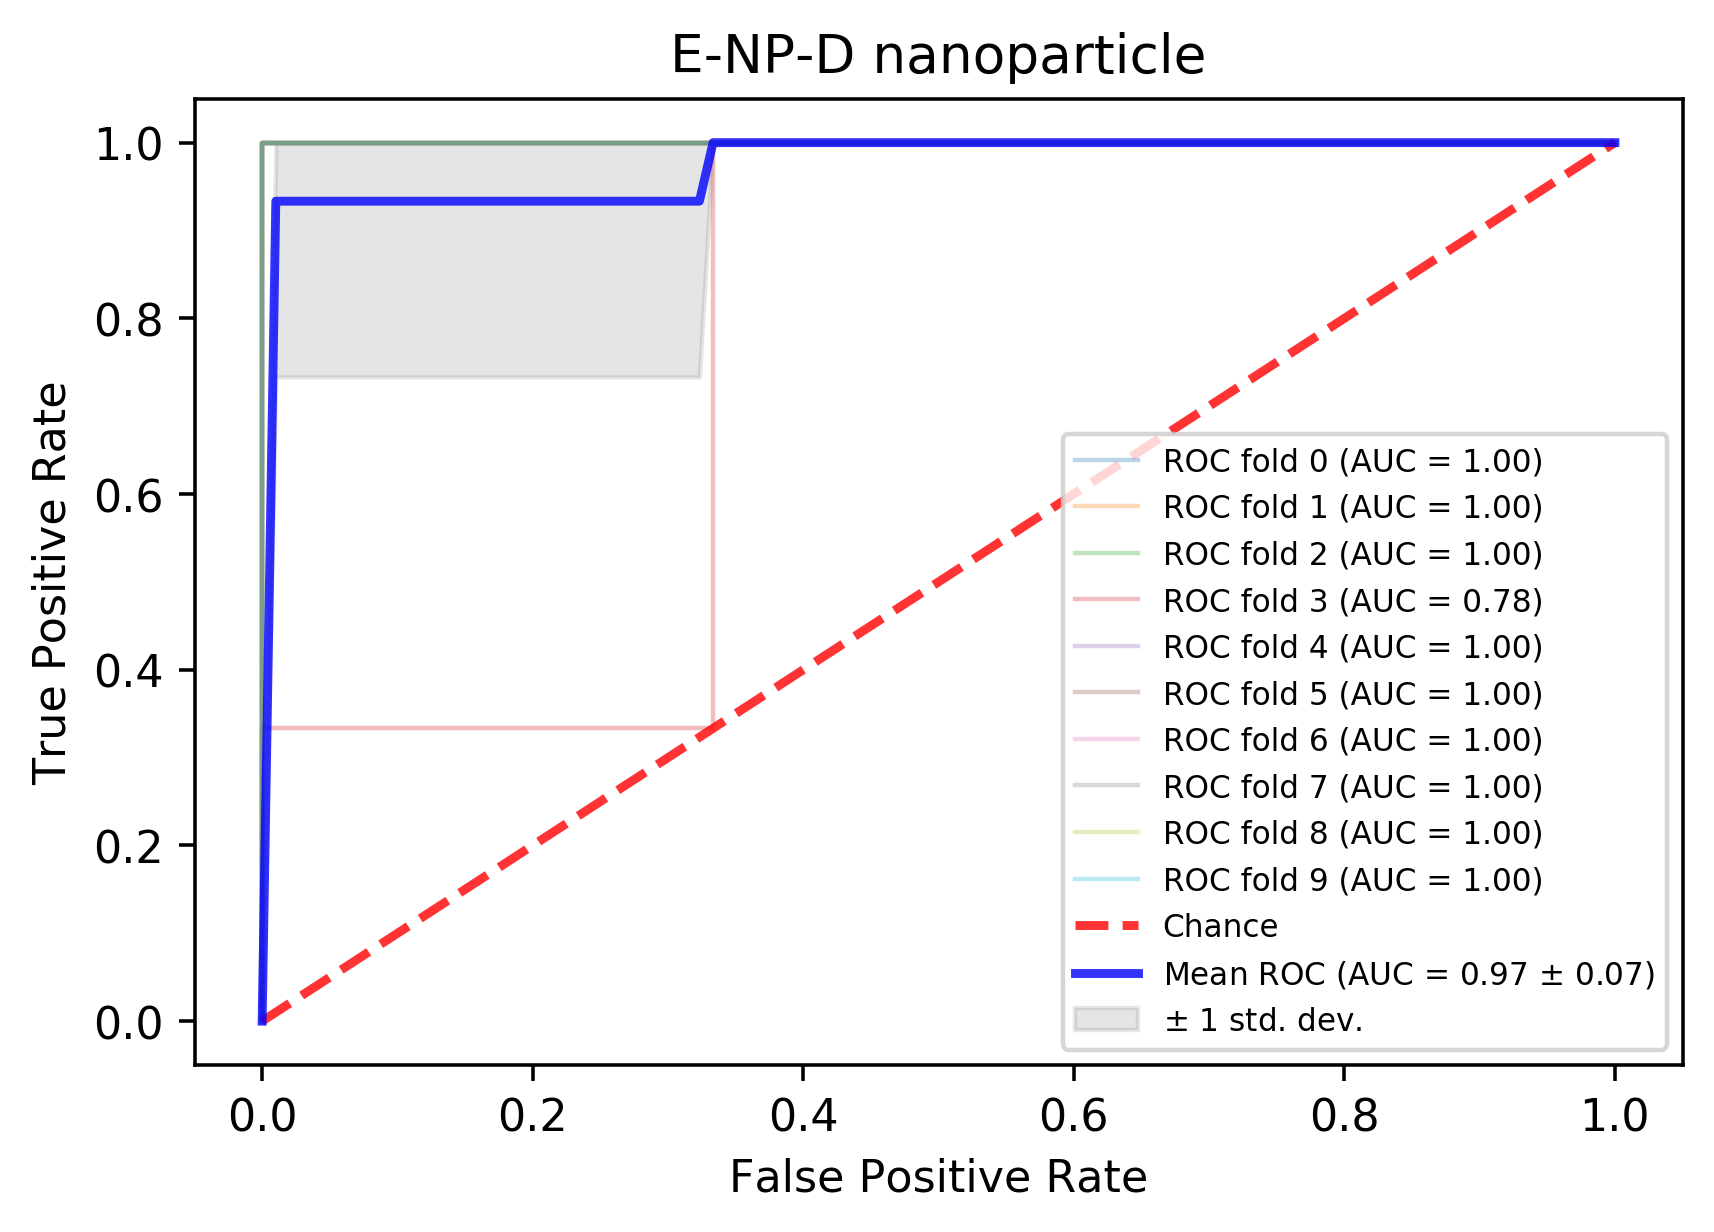

In [12]:
auc_plot = plt_save_path + phenotype +comparison_lab_save +"_RF_all_features_ROCAUC.png"
plot_roc_cv(clf, X, y, title=f"{phenotype_titles[phenotype]}", save=auc_plot)

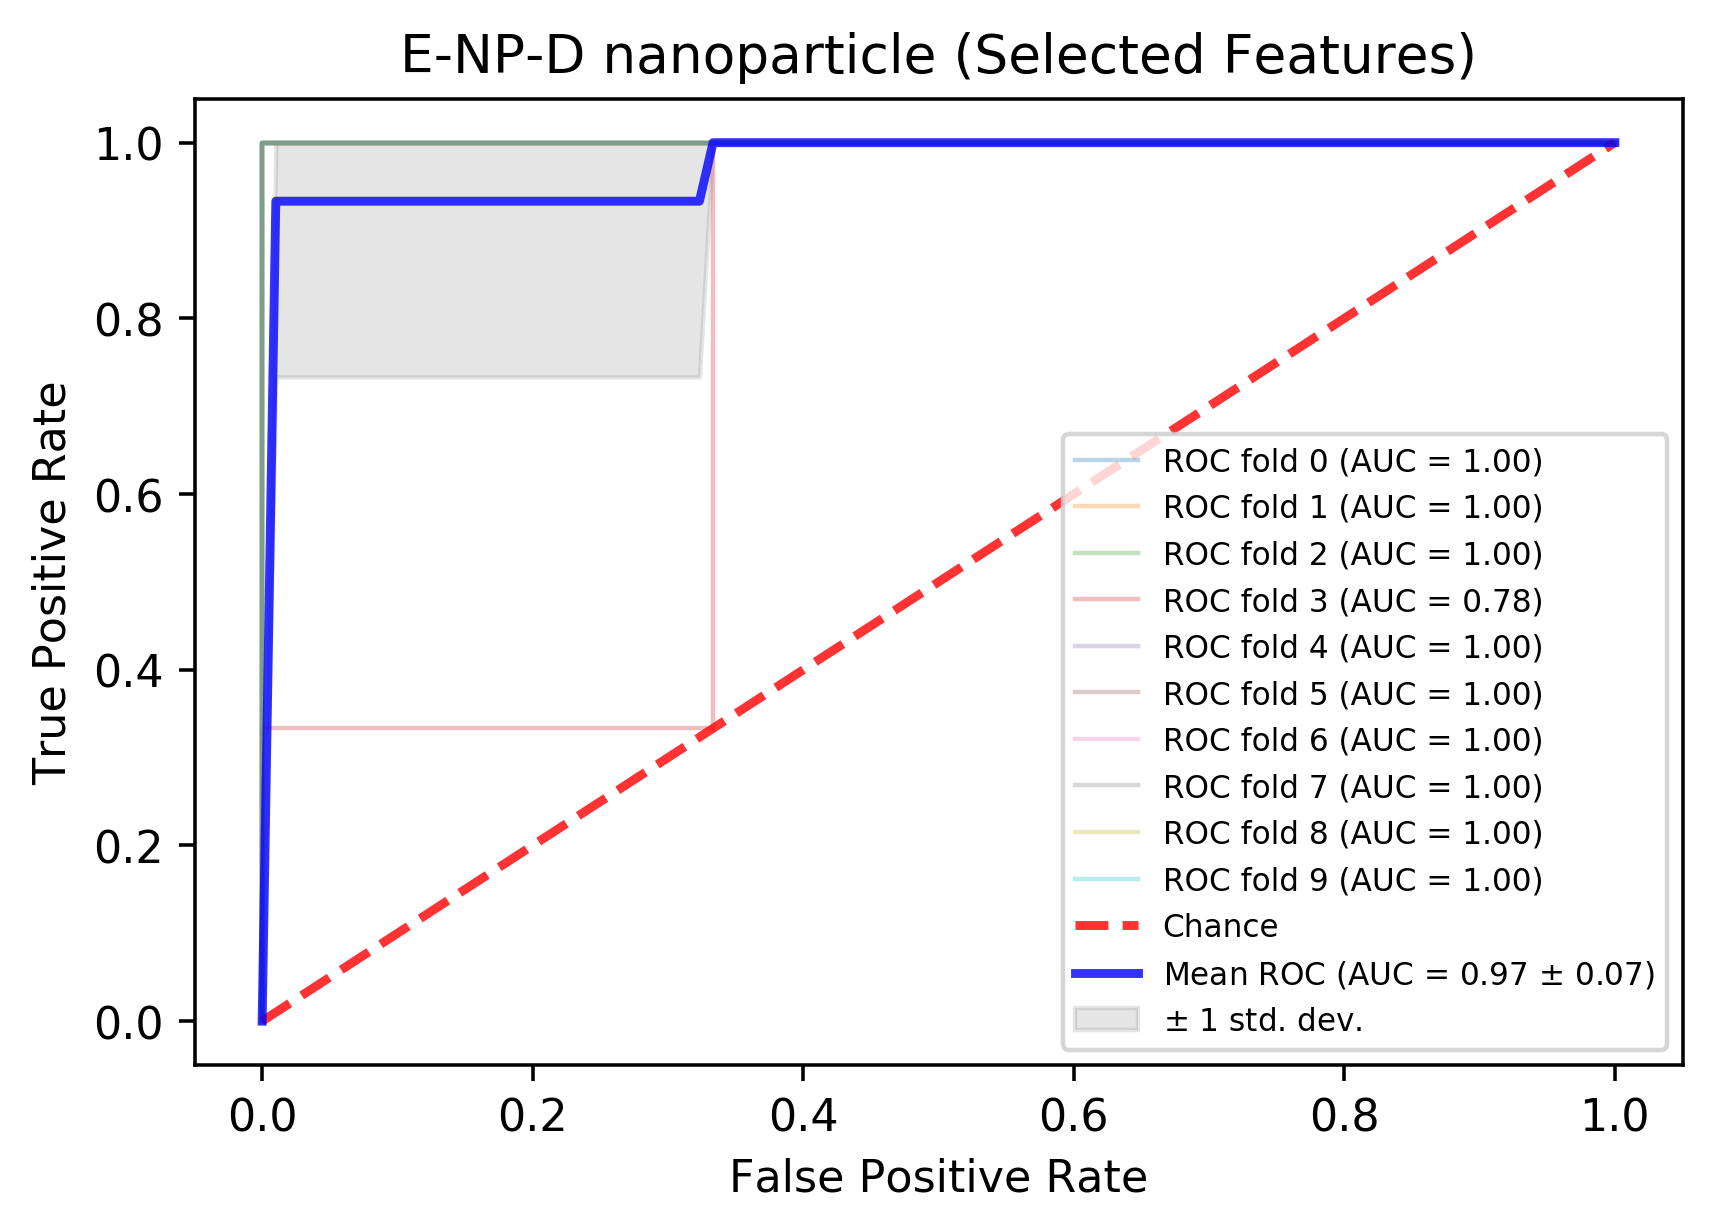

In [13]:
auc_plot = plt_save_path + phenotype + comparison_lab_save +"_RF_selected_features_ROCAUC.png"
plot_roc_cv(clf_selected, X, y, title=f"{phenotype_titles[phenotype]} (Selected Features)",
           save=auc_plot)

### Confusion Matrix RF model without feature selection

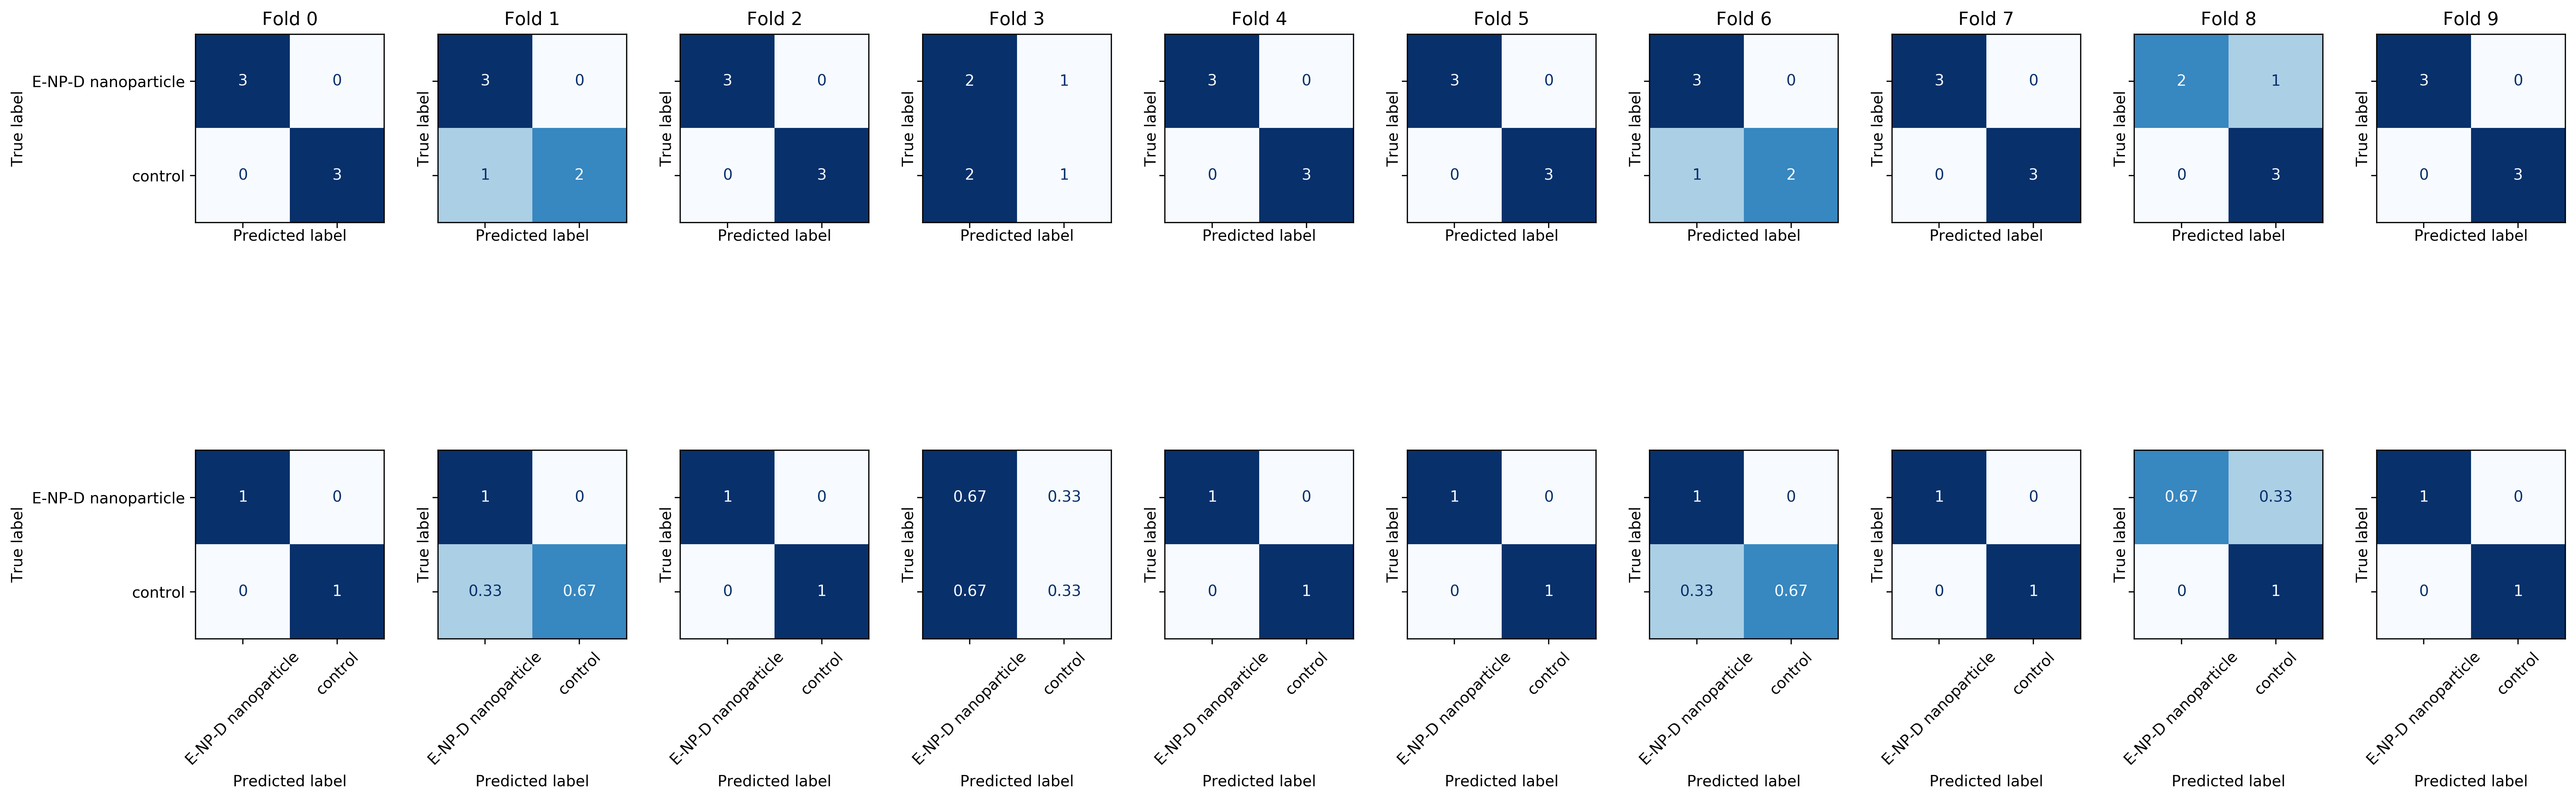

In [14]:
auc_plot = plt_save_path + phenotype + comparison_lab_save+"_RF_all_features_confusionmatrix.png"
confusion_matrix_analysis(clf, X, y, save=auc_plot)

### Confusion Matrix RF model WITH feature selection

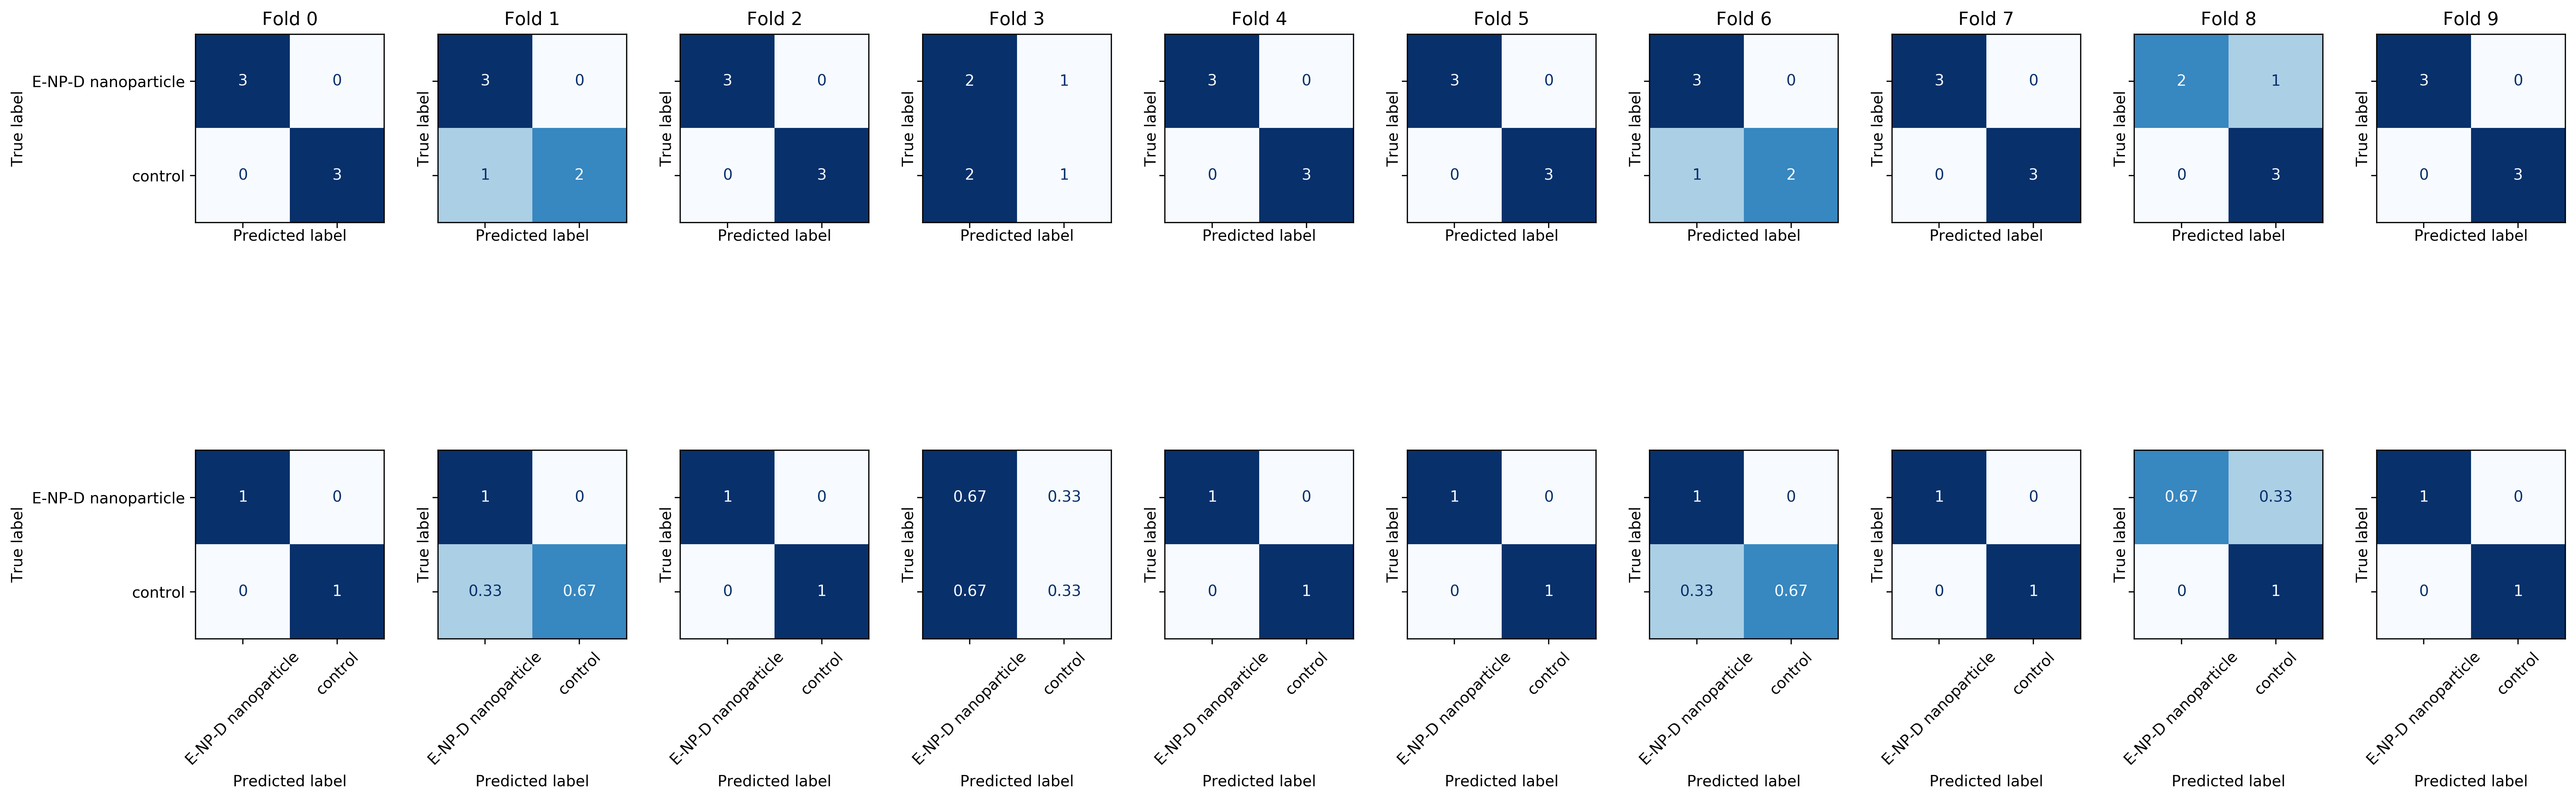

In [15]:
auc_plot = plt_save_path + phenotype + comparison_lab_save+"_RF_selected_features_confusionmatrix.png"
confusion_matrix_analysis(clf_selected, X, y, save=auc_plot)